# Main Code for DS2500 Project

In [137]:
import sklearn
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

First data file: dashboard data (no current information about closings, but it does have the latitude and longitude of each public beach in Massachusetts)

In [130]:
df = pd.read_excel('closings/BeachDashboardData-09-05.xlsx')
df = df[df["Marine or Freshwater"]=="Marine"]
df = df.drop(columns=["Closure Status Beach", "Marine or Freshwater"])
df.head(5)

,Town,Beach Name,Latitude,Longitude
9,Aquinnah,Lobsterville,41.353757,-70.819183
10,Aquinnah,Moshup Beach,41.349380,-70.836215
11,Aquinnah,Philbin Beach,41.339342,-70.831048
12,Aquinnah,Red Beach,41.343526,-70.784030
23,Barnstable,Covell's,41.635605,-70.334955


Second data file: shapefile of Masachusetts beaches (filtered to only the beaches in the dashboard data, since this file comes from the EPA, ie not all beaches in this file are public bathing beaches)

In [131]:
geodf = gpd.read_file("geodata/MARINEBEACHES_PT.shp")
geodf = geodf[["BEACHNAME", "geometry"]]
geodf = geodf.rename(columns={"BEACHNAME": "Beach Name"})
geodf = geodf.loc[[val in list(df["Beach Name"]) for val in list(geodf["Beach Name"])]]
geodf.head(5)

,Beach Name,geometry
59,Crocker Park,POINT (253560.704 917110.151)
60,Crocker Park,POINT (253557.294 917108.531)
61,Crocker Park,POINT (253559.364 917108.831)
62,Crocker Park,POINT (253555.244 917112.971)
63,Crocker Park,POINT (253555.354 917114.561)


Example of the third data file: A csv of closed beaches along with the type of beach and the reason for closing

In [132]:
example = pd.read_csv(f'closings/BeachPostingTbl-07-05-23.csv')
example.head(5)

,Municipality,Beach,Beach Type,Posting Reason
0,Agawam,Robinson Pond Beach (DCR),Freshwater,Bacterial Exceedance
1,Ashby,Damon Pond Beach (DCR),Freshwater,Bacterial Exceedance
2,Athol,Ellis Beach,Freshwater,Bacterial Exceedance
3,Beverly,Dane Street - Bathhouse,Marine,Bacterial Exceedance
4,Beverly,Brackenbury,Marine,Bacterial Exceedance


## Feature Engineering: Beach Closings by Week

All files were read in and filtered to marine beaches closed for bacterial exceedance to give us a list of closed beaches for that day. The information was put into a matrix with the columns as dates (all in July) and the rows as True (beach was closed on that day) or False (beach was open on that day)

In [138]:
filenames = os.listdir("closings")[1:]

closings = pd.DataFrame()
for filename in filenames:
    beach = pd.read_csv(f'closings/{filename}')
    beach = beach[(beach["Posting Reason"]=="Bacterial Exceedance") & (beach["Beach Type"]=="Marine")]
    closed_beaches = list(beach["Beach"])

    date = filename.split("-")[2]

    closings[int(date)] = df['Beach Name'].apply(lambda x: x in closed_beaches)

closings.head(5)


,5,6,7,10,12,13,14,17,18,19,20,21,24,25,26,27
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In order to turn this into features, we expressed these values as percent of the time that the beach was closed each week. For each week, we filtered the matrix of closings for only the days in those week, and calculated the percentage of time each beach was closed during that week. Then, we appended this to the dataframe of all beaches

In [134]:
calendar = {"W1 % Closed":range(1,9),
            "W2 % Closed":range(9,16),
            "W3 % Closed":range(16,23)}

for key, value in calendar.items():
    dates_in_week = [date for date in list(closings.columns) if date in value]
    filtered_df = closings[dates_in_week]
    total_closings = filtered_df.sum(axis=1)
    percent_closings = total_closings.apply(lambda x: x/len(dates_in_week))

    df[key]= percent_closings    

Histogram of beach closings - the majority of beaches were open, so if we were to use just this data by itself our model would likely overfit. However, we hope by incorperating location information (latitude and longitude) and weather information (rainfall), we can get a better model

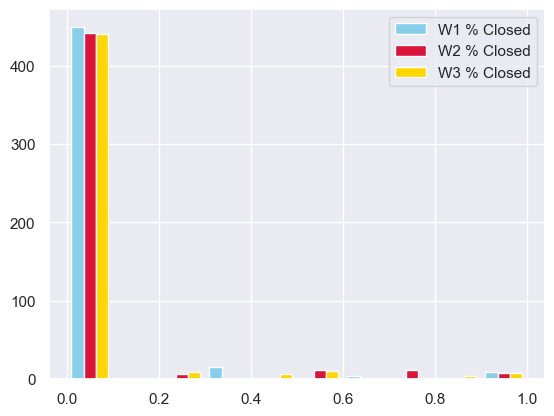

In [135]:
sns.set_theme()
plt.hist(df[["W1 % Closed", "W2 % Closed", "W3 % Closed"]], color=['skyblue','crimson','gold'], 
         label=["W1 % Closed", "W2 % Closed", "W3 % Closed"])
plt.legend()